# Вебинар 7. Рекомендательные системы в бизнесе

### Этапы:

1. Подготовка датасета:  **prefiltering; как выбрать таргет/вес?**
2. Обучение рекоммендательной системы:  **выбор библиотек и модели; cold start**
3. Деплой в продакшн:  **speed**
4. Показ рекоммендаций:  **postfiltering; во сколько показывать?; как часто?**
5. Рекомендации приносят пользу бизнесу:  **A/B тесты; оптимизация бизнес-, а не ML-метрик**

----

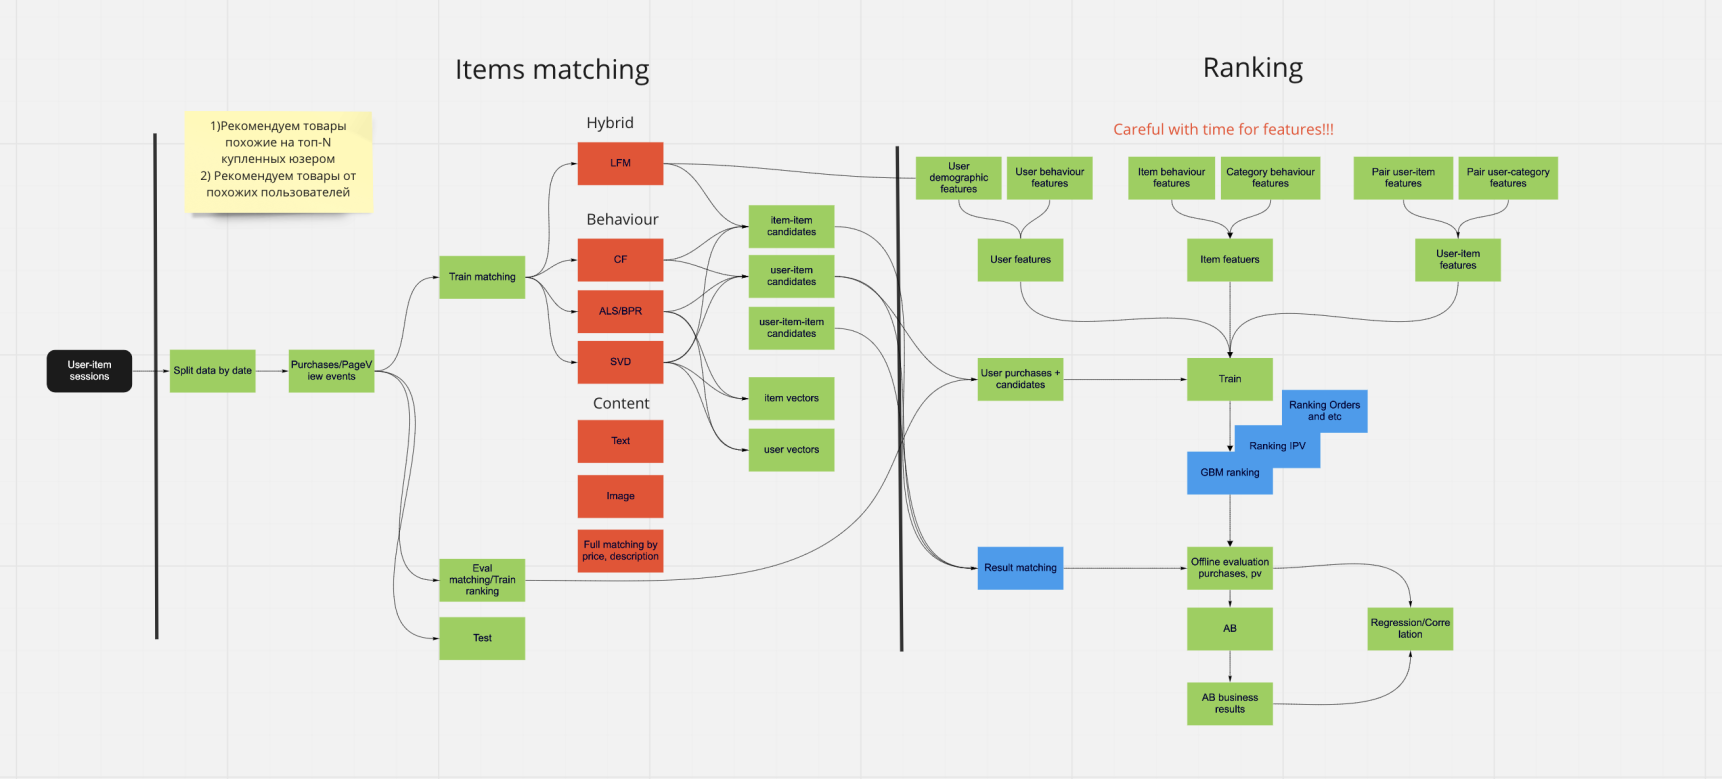

# Netflix recommend system

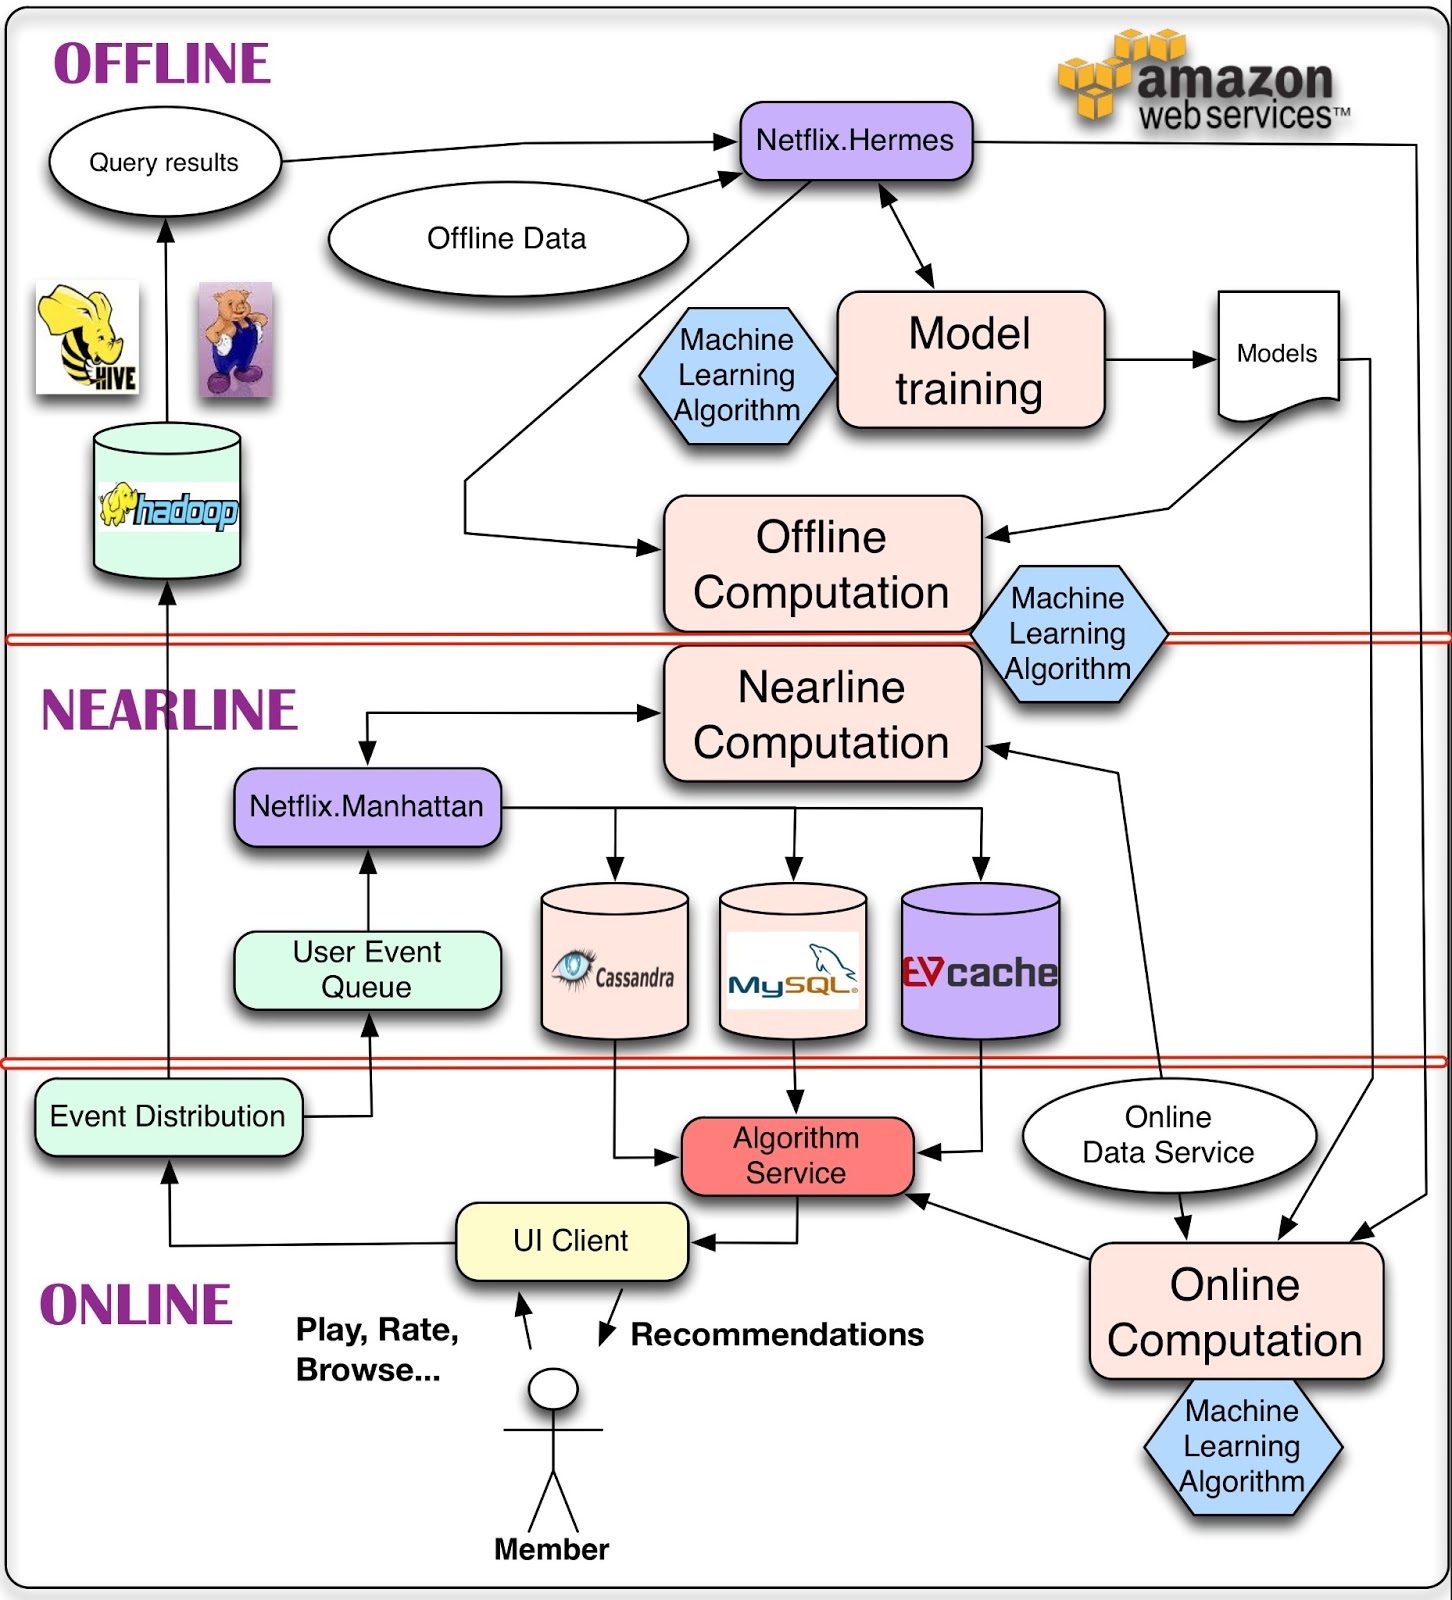

## 1. Подготовка датасета

### 1.1 Prefiltering

Можно заранее отфильтровать часть юзеров/товаров (~эвристичкский фильтр в многоуровневой модели рекоммендаций) 

*Товары:*
- По популярности (> 10 покупок в неделю)
- По давности покупки (Был продан хотя бы 1 раз за последние 6 месяцев)
- По цене (Цена > 30 руб, не имеет смысла рекомендовать более дешевые)
- По прибыльности (прибыльность товара > 5%)
- ...

*Юзеры:*
- По кол-ву покупок
- По давности покупки
- По среднему чеку
- ...

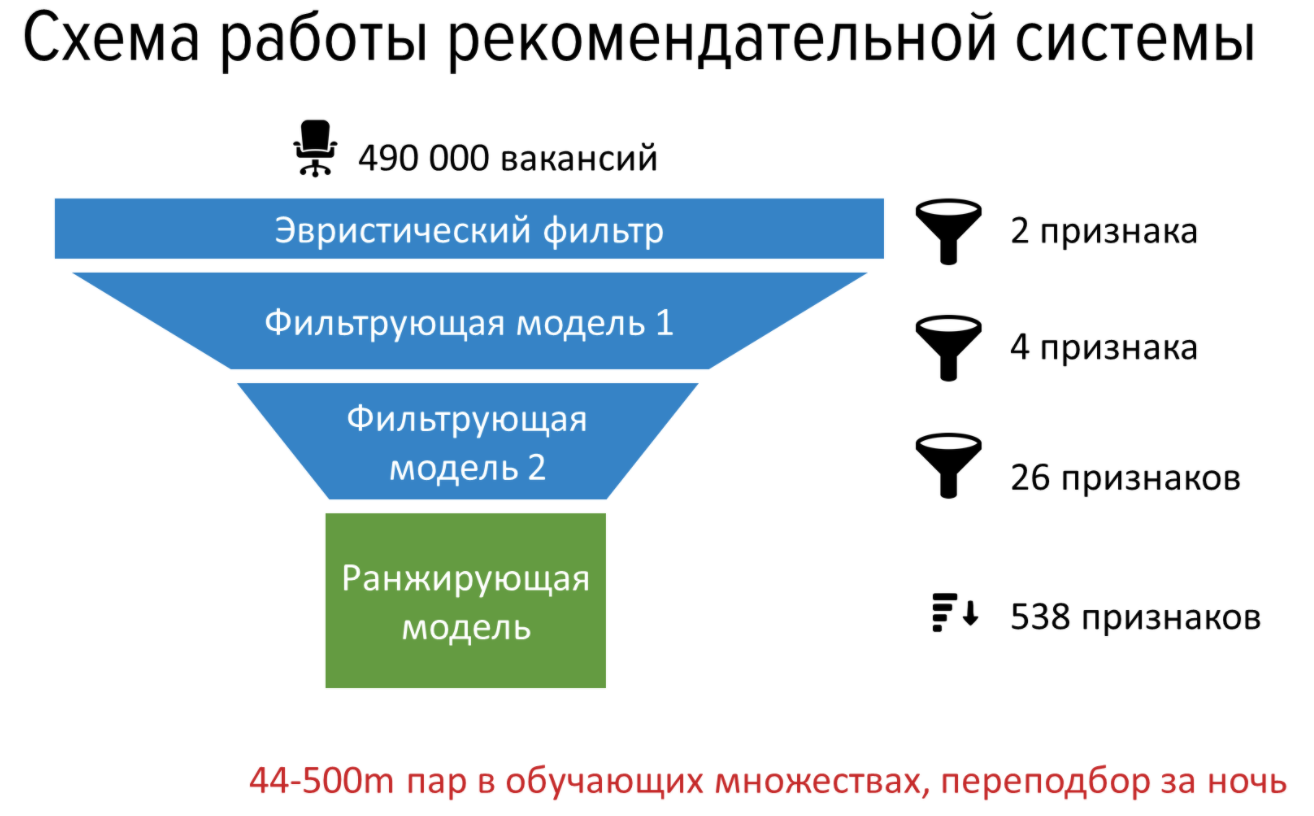


### 1.2 Выбор таргета / веса таргета

Выбираем таргет так, чтобы он:
- Отражал бизнес-метрики (взвешиваем по денежному вкладу)
- Можно было посчитать для многих юзеров (просмотр --> клик --> добавление в корзину --> покупка) 

взвешанный таргет = 1*просмотр + 3*клик + 7*добавление в корзину + 15*покупка / (1+3+7+15)

---

## 2. Обучение рекомендательной системы

### 2.0 Выбор типа задачи (лосс в т.ч.)

### 2.1 Выбор библиотек и модели

Выбирвем *быстрые* библиотеки с *полезными* фичами
- *implicit* (Item-Item, ALS, BPR)
- *lightFM* (hybrid)
- *LightGBM* (gradient boosting trees)
- *Spotlight* (Neural Networks)

### 2.2 Cold start

Варианты:
- НЕ рекомендовать ничего "холодным" юзерам, не рекомендовать "холодные товары"
- Использовать контентные / гибридные рекоммендательные системы
- Предсказывать эмбеддинги холодных товаров / юзеров, [видео Яндекс.Дзена, 15-25 минуты](https://www.youtube.com/watch?v=TaUqh_CeCPc&t=126s)

*TL; DR Предсказывать эмбеддинги холодных товаров / юзеров*
1. Обучаем модель ALS на *горячих* юзерах и товарах
2. Получаем их эмбеддинги
3. Обучаем модель LightGBM / NN предсказывать эмбеддинги *горячих* юзеров и товаров по их мета-данным
4. Предсказывем эмбеддинги холодных юзеров и товаров
5. В продакшн просто перемножаем итоговые эмбеддинги юзеров и товаров (~ALS)

---

## 3. Деплой в продакшн

### 3.1 Speed

Существуют специальные библиотеки для быстро работы с эмбеддингами, поиском похожих юзеров и товаров
- FAISS (Facebook AI Similarity Search)
- NMSlib (Non-Metric Space library)
- ANNOY (Approximate Nearest Neighbors Oh Yeah) 

---

## 4. Показ рекомендаций

### 4.1 Postfiltering
Можно получить ранжированный список > N товаров, а потом его отфильтровать до N
- Повторяющиеся товары
- Товары из одной и той же категории 
- Только те, которые продаются в городе/магазине юзера
- ...

In [1]:
import pandas as pd

item_features = pd.read_csv('../data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [2]:
item_features['department'].nunique()

44

In [3]:
item_features['commodity_desc'].nunique()

308

In [4]:
item_features['sub_commodity_desc'].nunique()

2383

In [10]:
# берем с запасом
recommendations = [ 26738, 26738, 26941, 25671, 26081, 26093, 18293696, 18294080, 18316298, 29247, 29252, 29340]

In [11]:
def postfilter(recommendations, item_info, N=5):
    """Пост-фильтрация товаров
    
    Input
    -----
    recommendations: list
        Ранжированный список item_id для рекомендаций
    item_info: pd.DataFrame
        Датафрейм с информацией о товарах
    """
    
    # Уникальность
#     recommendations = list(set(recommendations)) - неверно! так теряется порядок
    unique_recommendations = []
    [unique_recommendations.append(item) for item in recommendations if item not in unique_recommendations]
    
    # Разные категории
    categories_used = []
    final_recommendations = []
    
    CATEGORY_NAME = 'sub_commodity_desc'
    for item in unique_recommendations:
        category = item_features.loc[item_features['item_id'] == item, CATEGORY_NAME].values[0]
        
        if category not in categories_used:
            final_recommendations.append(item)
            
        unique_recommendations.remove(item)
        categories_used.append(category)
    
    n_rec = len(final_recommendations)
    if n_rec < N:
        final_recommendations.extend(unique_recommendations[:N - n_rec])
    else:
        final_recommendations = final_recommendations[:N]
    
    assert len(final_recommendations) == N, 'Количество рекомендаций != {}'.format(N)
    return final_recommendations

In [12]:
postfilter(recommendations, item_info=item_features, N=5)

[26738, 25671, 26093, 18294080, 29247]

### 4.2 Во сколько рекомендовать?

1. Из бизнес логики
2. Аналитически:
    - Делаем рассылки в различное время
    - Берем юзеров, которые открыли письма с рекоммендациями через Х часов после рассылки (многие открывают мгновенно после получения письма, вне зависимости от того, во сколько они ег ополучили)
    - Считаем среднее / медианное время открытия письма
    

### 4.3 Как часто рекомендовать?

Из бизнес-логики

---

## 5. Рекомендации приносят пользу бизнесу

### 5.1 А/В тесты

Неплохое [введение](https://www.optimizely.com/optimization-glossary/ab-testing/) в А/В тесты

*TL;DR*
- Берем 2 случайные подвыборки пользователей --> группа А и В
- В группе А ничего не меняем, в группе В - меняем (новая recsys, postfiltering, ...)
- Через некоторое время измеряем средние метрик в группах А/В
- Проверям отличаются ли статистически эти средние

### 5.2 Оптимизация бизнес-, а не ML-метрик

Видео с митапа [vk, с 43 минуты](https://vk.com/video-17796776_456239372)

*TL; DR* - упрощенная версия
- Строим k моделей, каждая из которых предсказывает свое 0/1 действие (клик, лайк, репост, комментарий, ...)
- $p = \theta_1 * p_1 + ... + \theta_k * p_k$, $\sum \theta_i = 1$
- Как выбрать $\theta_i$?
- Проводим много эскпериментов с разными $\theta_i$
- Строим регрессию бизнес метирки на все $\theta_i$ - SVM
- Получаем зависимость бизнес метрики от $\theta_i$
- Максимизируем бизнес метрику, изменяяя $\theta_i$